In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [122]:
class Cell:
    """
    Class representing a cell of a regular CW complex
    """
    
    def __init__(self, dim, boundary=None, display_name=None):
        """
        dim is the dimension of the cell
        boundary is a list of cells of dimension dim-1
        """
        if boundary is None:
            boundary = []
        
        assert dim >= 0
        for cell in boundary:
            assert cell.dim == dim-1

        self.dim = dim
        self.boundary = boundary
        self.faces = set(boundary)
        for cell in boundary:
            self.faces = self.faces.union(cell.faces)
        self.display_name = display_name


class RegularCWComplex:
    """
    Class representing a regular CW complex
    """
    
    def __init__(self, levels):
        """
        levels = [[Cell]], levels[i] = X_i of the CW complex
        """
        self.levels = levels
    
    def add_cells(self, dim, cells):
        # Add
        return
    
    def boundary_matrix(self, dimension):
        # Returns a matrix for the boundary map X_n -> X_{n-1}
        return
    
    def plot_hasse_diagram(self):
        # Plot the Hasse diagram for the face poset of the CW complex
        return

def gradient_path_rank(cell_sequence):
    # TODO
    # return the rank function of the morphism represented by this sequence
    return

class GradientPath:
    """
    Class representing a morphism in the discrete flow category
    """
    
    def __init__(self, cell_sequence):
        self.cell_sequence = tuple(cell_sequence)
        self.rank = gradient_path_rank(cell_sequence)
    
    def __eq__(self, other):
        return self.cell_sequence == other.cell_sequence


In [123]:
# Define the cells in the CW complex
x = Cell(0, None, "x")
y = Cell(0, None, "y")
z = Cell(1, [x, y], "z")
w = Cell(1, [x, y], "w")
t = Cell(2, [z, w], "t")
b = Cell(2, [z, w], "b")
f = Cell(3, [b, t], "f")

In [124]:
# Define the acyclic partial matching corresponding to our discrete Morse function
X = [x, y, z, w, t, b, f] # X is the CW complex
mu = [-1]*len(X)
mu[1] = 3 # mu(y) = w
mu[2] = 5 # mu(z) = b

print(mu)

[-1, 3, 5, -1, -1, -1, -1]


In [125]:
def get_directed_graph(X, mu, source, target):
    # Get the directed graph where v -> w if w < v or mu(v) = w 
    
    # Later optimization: ensure only the elements in the interval [target, source] are in the graph
    graph = [] # Adjacency list representation (but with sets)
    for i in range(len(X)):
        graph.append(set())
        # This is kind of wonky. Maybe I should drop the Cell class and just use integers and adjacency lists instead
        for j in range(len(X)):
            if X[j] in X[i].faces:
                graph[i].add(j)
        if mu[i] != -1:
            graph[i].add(mu[i])
    return graph

def get_simple_paths(graph, source, target, cur_path=None):
    # Traverse the graph to get all paths from source to target that doesn't repeat vertices
    if cur_path == None:
        cur_path = [source]
    elif cur_path[-1] == target:
        return [list(cur_path)]
    
    visited = set(cur_path)
    paths = []
    for cell in graph[cur_path[-1]].difference(visited):
        cur_path.append(cell)
        paths.extend(get_simple_paths(graph, cur_path[-1], target, cur_path))
        cur_path.pop()
    
    return paths
    
# Want Hom(f, x)
source = 6 
target = 0

graph = get_directed_graph(X, mu, source, target)
simple_paths = get_simple_paths(graph, source, target)
print(simple_paths)


[[6, 0], [6, 1, 3, 0], [6, 2, 0], [6, 2, 1, 3, 0], [6, 2, 5, 0], [6, 2, 5, 1, 3, 0], [6, 2, 5, 3, 0], [6, 3, 0], [6, 4, 0], [6, 4, 1, 3, 0], [6, 4, 2, 0], [6, 4, 2, 1, 3, 0], [6, 4, 2, 5, 0], [6, 4, 2, 5, 1, 3, 0], [6, 4, 2, 5, 3, 0], [6, 4, 3, 0], [6, 5, 0], [6, 5, 1, 3, 0], [6, 5, 2, 0], [6, 5, 2, 1, 3, 0], [6, 5, 3, 0]]


In [126]:
def rho(path):
    rank = 0
    for i in range(len(path)-1):
        if X[path[i]].dim > X[path[i+1]].dim:
            rank += X[path[i]].dim - X[path[i+1]].dim - 1
    return rank

Hom = []
for rank in range(X[source].dim-X[target].dim):
    # Hom[i] is morphisms of rank i
    Hom.append([])

for path in simple_paths:
    Hom[rho(path)].append(path)

In [128]:
def path_string(path):
    # TODO: don't use X as a global variable

    s = X[path[0]].display_name
    for i in range(1, len(path)):
        if X[path[i-1]].dim > X[path[i]].dim:
            s += " > "
        else:
            s += " < "
        s += X[path[i]].display_name
    return s

class GradientPath(Cell):
    def __init__(self, path, dim, boundary=None):
        self.path = path
        display_name = path_string(path)
        super().__init__(dim, boundary, display_name)

# Now, compute edges between layers
def covers(x, y):
    # Returns true if x covers y, i.e., if rho(x)=rho(y)+1 and x > y
    if x.dim != y.dim + 1:
        return False

    if len(x.path) == len(y.path) + 1:
        # There are probably slightly faster ways to do this
        return len(set(x.path).difference(y.path)) == 1
    elif len(x.path) == len(y.path) - 1:
        return len(set(y.path).difference(x.path)) == 1
    return False

def get_boundary(path, Hom_lower_rank):
    bdy = []
    for other in Hom_lower_rank:
        if adj_rank_covers(path, other.path):
            bdy.append(other)
    return bdy

HomCW = []
for rank in range(len(Hom)):
    HomCW.append([])
    for path in Hom[rank]:
        boundary = []
        if rank > 0:
            boundary = get_boundary(path, HomCW[rank-1])
        HomCW[rank].append(GradientPath(path, rank, boundary))



In [134]:
for rank in range(len(Hom)-1, -1, -1):
    print(f"Rank {rank}")
    for grad_path in HomCW[rank]:
        print(grad_path.display_name, "covers:")
        print([bdy.display_name for bdy in grad_path.boundary])
        print()
    print()

Rank 2
f > x covers:
['f > z > x', 'f > w > x', 'f > t > x', 'f > b > x']

f > y < w > x covers:
['f > z > y < w > x', 'f > w > x', 'f > t > y < w > x', 'f > b > y < w > x']

f > z < b > x covers:
['f > z > x', 'f > z < b > w > x', 'f > t > z < b > x', 'f > b > x']

f > z < b > y < w > x covers:
['f > z > y < w > x', 'f > z < b > w > x', 'f > t > z < b > y < w > x', 'f > b > y < w > x']


Rank 1
f > z > x covers:
['f > t > z > x', 'f > b > z > x']

f > z > y < w > x covers:
['f > t > z > y < w > x', 'f > b > z > y < w > x']

f > z < b > w > x covers:
['f > t > z < b > w > x', 'f > b > z > x', 'f > b > z > y < w > x', 'f > b > w > x']

f > w > x covers:
['f > t > w > x', 'f > b > w > x']

f > t > x covers:
['f > t > z > x', 'f > t > w > x']

f > t > y < w > x covers:
['f > t > z > y < w > x', 'f > t > w > x']

f > t > z < b > x covers:
['f > t > z > x', 'f > t > z < b > w > x', 'f > b > z > x']

f > t > z < b > y < w > x covers:
['f > t > z > y < w > x', 'f > t > z < b > w > x', 'f > b 

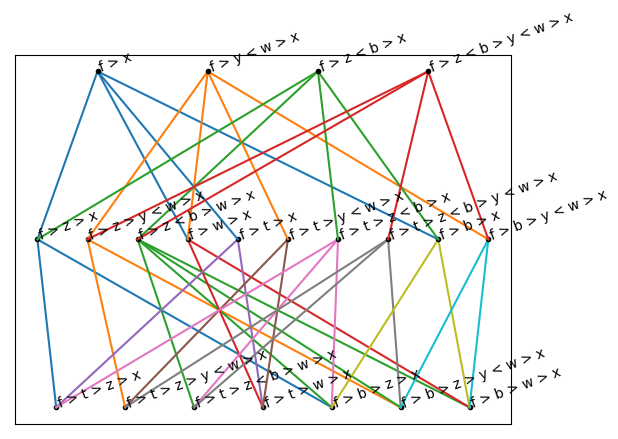

In [147]:
def plot_lattice(Cells_by_rank):
    # Create mapping from cells to coordinates (y-axis being rank), and plot points and edges
    coords = {}
    max_rank = len(Cells_by_rank)
    y_coord = np.arange(0, max_rank+1)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    for rank in range(max_rank):
        x_coord = np.linspace(0, 100, len(Cells_by_rank[rank])+2)
        for i in range(len(Cells_by_rank[rank])):
            color = colors[i % len(colors)]
            cell = Cells_by_rank[rank][i]
            x = x_coord[i+1]
            y = y_coord[rank]
            coords[id(cell)] = [x, y]
            for covered in cell.boundary:
                x2, y2 = coords[id(covered)]
                plt.plot([x, x2], [y, y2], color=color)
            plt.plot(x, y, 'k.')
            plt.annotate(cell.display_name, (x, y), rotation=20)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("CW_lattice.pdf")
    plt.show()

plot_lattice(HomCW)

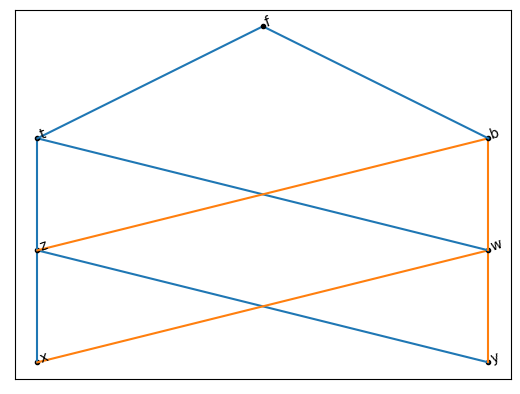

In [146]:
def order_by_dim(cell_list, max_rank):
    cells_by_dim = []
    for i in range(max_rank+1):
        cells_by_dim.append([])
    for cell in cell_list:
        cells_by_dim[cell.dim].append(cell)
    return cells_by_dim
X_by_dim = order_by_dim(X, 3)
plot_lattice(X_by_dim)